# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets #Retirar após o uso do dataset do Hackday
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Global variables

In [2]:
rawData = pd.DataFrame()
outliersData = pd.DataFrame()

# Functions

In [8]:
def loadData(x: str):
    """Função para carregar arquivo csv com a base de dados"""
    global rawData
    if not os.path.exists(x):
        print("Arquivo não encontrado.")
        return None
    rawData = pd.DataFrame(pd.read_csv(x))
    print(f"Sample do dataframe:\n{rawData.sample(5)}")
    return

def checkData():
    print(f"Descrição dos dados:\n{rawData.describe()}\n")
    print(f"Número de nulos por coluna:\n{rawData.isnull().sum()}\n")
    print(f"Tipos das colunas:\n{rawData.dtypes}\n")
    return

def checkCorrelation():
    plt.figure(figsize=(10,8))
    sns.heatmap(rawData.select_dtypes(include=[np.number]).corr(), annot=True)
    plt.show()
    return

def checkOutliers():
    global outliersData
    outliers_df = pd.DataFrame()
    # Itera sobre as colunas númericas
    for column in rawData.select_dtypes(include=[np.number]).columns:
        # Calcula o 1 quartil (Q1)
        Q1 = rawData[column].quantile(0.25)
        # Calcula o 3 quartil (Q3)
        Q3 = rawData[column].quantile(0.75)
        # Calcula o Intervalo Interquartil (IQR)
        IQR = Q3 - Q1
        # Define os limites inferior e superior para outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Identica os outliers da coluna atual e adiciona ao DataFrame de outliers
        outliers = rawData[(rawData[column] < lower_bound) | (rawData[column] > upper_bound)]
        # Concatene os outliers da coluna atual ao DataFrame de outliers
        outliers_df = pd.concat([outliers_df, outliers])
    outliersData = outliers_df.drop_duplicates().reset_index(drop=True)
    print(f"Sample de outliers:\n{outliersData.sample(5)}")
    return


# Loading data

In [9]:
loadData("dataset/concatData.csv")

/tmp/ipykernel_10563/3062628536.py:7: DtypeWarning: Columns (8,9,20,33) have mixed types. Specify dtype option on import or set low_memory=False.
  rawData = pd.DataFrame(pd.read_csv(x))


Sample do dataframe:
       book_id               title_x author_id first_name last_name  \
469309   TM925     The Mallemaroking     BT132     Bianca  Thompson   
390309   TM925     The Mallemaroking     BT132     Bianca  Thompson   
411631   TM925     The Mallemaroking     BT132     Bianca  Thompson   
108707   HS107  Hashtag QuokkaSelfie     LL585   Langston   Lippman   
265187   TM925     The Mallemaroking     BT132     Bianca  Thompson   

         birthday country_residence  hrs_writing_day               title_y  \
469309  28/1/2150     United States              5.0     The Mallemaroking   
390309  28/1/2150     United States              5.0     The Mallemaroking   
411631  28/1/2150     United States              5.0     The Mallemaroking   
108707  2/10/2147       New Zealand              0.0  Hashtag QuokkaSelfie   
265187  28/1/2150     United States              5.0     The Mallemaroking   

          award_name  ...       city       state  country year_established  \
46930

# Descrição

In [10]:
checkData()

Descrição dos dados:
       hrs_writing_day       year_won      format_id          pages  \
count    518277.000000  346753.000000  518276.000000  518276.000000   
mean          5.785934    2180.725594       3.807334     470.781142   
std           1.870767       3.597522       1.507262     312.486212   
min           0.000000    2179.000000       1.000000      11.000000   
25%           5.000000    2179.000000       3.000000     187.000000   
50%           5.000000    2179.000000       4.000000     432.000000   
75%           6.000000    2182.000000       5.000000     784.000000   
max          13.000000    2193.000000       6.000000    1296.000000   

       print_run_size_k          price       genre_id  volume_number  \
count     518276.000000  518276.000000  518277.000000  326145.000000   
mean          30.016335      15.822849       5.176166       1.314330   
std           21.800581       7.275049       2.515430       0.834153   
min            2.000000       5.990000       1.0000

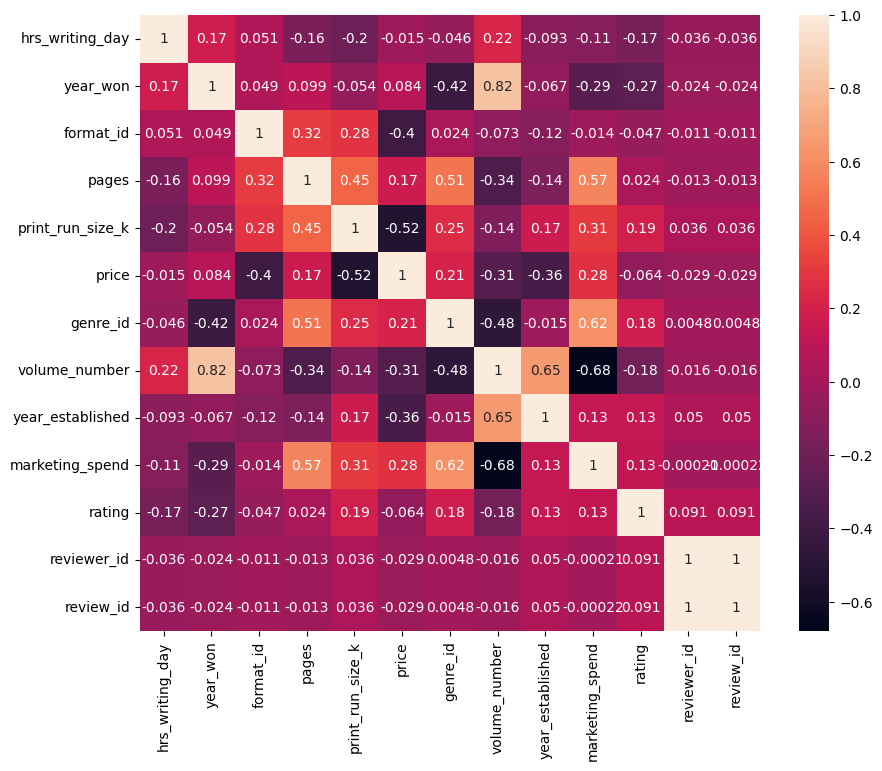

In [11]:
checkCorrelation()

In [19]:
checkOutliers()

Sample de outliers:
       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
3155   7.5000      14.0  7.402810   1.062451      4108.0  3.206870     37.13   
463    8.6030      52.0  7.673469   1.061224       518.0  2.642857     32.75   
1216   1.6607      16.0  6.710526   1.921053        85.0  2.236842     39.71   
213   15.0001      48.0  8.845161   1.058065       528.0  3.406452     34.19   
312   11.5706      36.0  7.682131   1.061856      1315.0  2.259450     37.87   

      Longitude  
3155    -121.60  
463     -117.18  
1216    -122.74  
213     -118.18  
312     -122.47  


# Feature Enginnering

# Filtragem de variáveis

# Ánalise exploratoria (EDA)

# Preparação dos dados

# Seleção de variáveis

# Treinamento e avaliação de modelos

## Regressão linear

In [ ]:
# Verificando o nome das colunas
column_names = rawData.columns.tolist()
print(column_names)

In [ ]:

X = rawData[column_names[0:-2]]
y = rawData[column_names[6:8]]
model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)
predictions.shape

## 2.7 - Fine Tuning

## 2.8 - Deploy

# Conclusões

## 3.2 - Insights